# Cookie Cats Video A/B game testing

The dataset here showcases an A/B test result of the Cookie Cats game to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. Consequently, this code analyses the impact of this on total amount of playtime and whether users were retained over time.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [2]:
data = pd.read_csv("cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


## Cleaning

In [3]:
print(f"there are {data.index.size} rows in the dataset")
print("Duplicate rows:", data.duplicated().sum())
print("NaN values per column:\n", data.isna().sum())
version_counts = data['version'].value_counts()
print(version_counts)

there are 90189 rows in the dataset
Duplicate rows: 0
NaN values per column:
 userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


As the purpose of this report is to study the influence of a factor on actual game time, it is only relevant to only look at people who actually played the game. However, in this dataset, as can be seen below, there are a large number of players who did not play a single round. As a consequence, I remove all these.

In [4]:
zeros_count = data['sum_gamerounds'].eq(0).sum()
print(f"There are {zeros_count} who have not played a single round")
data = data[data['sum_gamerounds'] != 0]
print("These have now been successfully removed")

There are 3994 who have not played a single round
These have now been successfully removed


I also convert the boolean indices into numbers so that they can be studied later (i.e., making all True's into a 1, and all 'False's into a 0).

In [5]:
data.loc[:, ['retention_1', 'retention_7']] = data[['retention_1', 'retention_7']].astype(int)

C:\Users\david\AppData\Local\Temp\ipykernel_17188\3882844810.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 1 ... 1 1 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.loc[:, ['retention_1', 'retention_7']] = data[['retention_1', 'retention_7']].astype(int)
C:\Users\david\AppData\Local\Temp\ipykernel_17188\3882844810.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.loc[:, ['retention_1', 'retention_7']] = data[['retention_1', 'retention_7']].astype(int)


In [6]:
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


### Distribution and Outliers of Data

As can be seen in the chart below, there are a variety of significant outliers, including one seemingly-mistaken datapoint having circa 50,000 games played (could be a bot). To get a better view, and as I intend to test for significance later using the Mann Whitney U Test (which is slightly skewed by the presence of outliers, these will be removed.

Promotion gate_30 - Outliers: 4921
Promotion gate_40 - Outliers: 4727


C:\Users\david\AppData\Local\Temp\ipykernel_17188\2881423565.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = data.groupby('version').apply(detect_outliers).reset_index(drop=True)


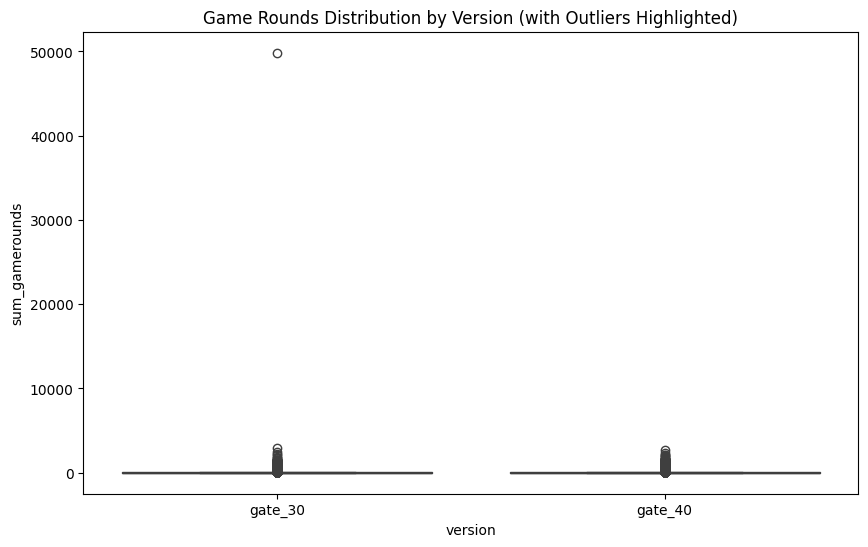

In [7]:
def detect_outliers(group):
    Q1 = group['sum_gamerounds'].quantile(0.25)
    Q3 = group['sum_gamerounds'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['sum_gamerounds'] < lower_bound) | 
                     (group['sum_gamerounds'] > upper_bound)]
    
    print(f"Promotion {group['version'].iloc[0]} - Outliers: {len(outliers)}")
    return outliers

outliers = data.groupby('version').apply(detect_outliers).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=data)
plt.title('Game Rounds Distribution by Version (with Outliers Highlighted)')
plt.show()


In [8]:
def remove_outliers(group):
    Q1 = group['sum_gamerounds'].quantile(0.25)
    Q3 = group['sum_gamerounds'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_group = group[(group['sum_gamerounds'] >= lower_bound) & 
                           (group['sum_gamerounds'] <= upper_bound)]
    
    print(f"Promotion {group['version'].iloc[0]} - Removed Outliers: {len(group) - len(filtered_group)}")
    return filtered_group

data = data.groupby('version', group_keys=False).apply(remove_outliers)

Promotion gate_30 - Removed Outliers: 4921
Promotion gate_40 - Removed Outliers: 4727


C:\Users\david\AppData\Local\Temp\ipykernel_17188\398560823.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('version', group_keys=False).apply(remove_outliers)


## Exploratory Data Analysis

Below we can see that even after removing significant outliers, there is still a very thin long tail when it comes to high values. One could consider removing this, but as we have already cleaned the data on numerous measures, I choose to maintain this.

As we can also see, the group with the gate placed at level 40 also has a slightly higher mean of games played (M = 26.30) versus when placed at level 30 (M = 25.54). Later we will test to see if this is significant.

We also see that there are slight differences in terms of the mean retention time of players. Namely, the group with the gate placed at level 30 shows a slight increase in the percentage of times the user returns to the game after a period of time. Specifically, 40.96% of users returned after 1 day versus 40.71% for the other group. Similarly, 12.56% returned after 7 days in the group with the gate placed at level 30, versus 11.99% with the other group. These differences are incredibly slight. Regardless, they will also be tested later to see if they are significant.

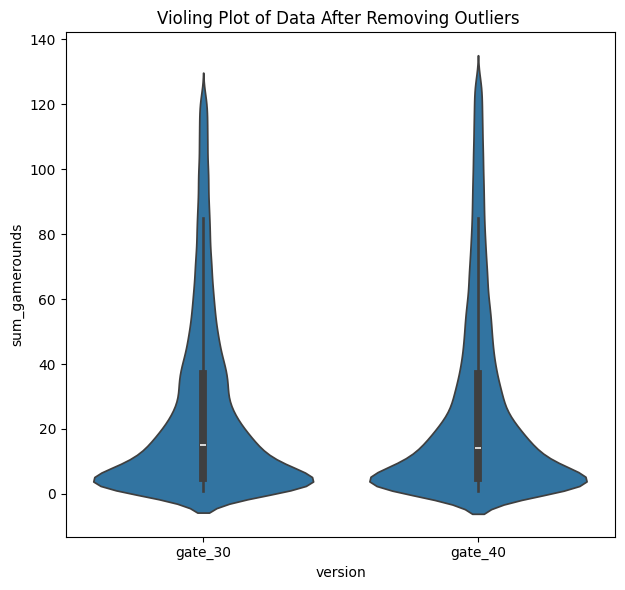

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
sns.violinplot(x='version', y='sum_gamerounds', data=data)
plt.title("Violing Plot of Data After Removing Outliers ")

plt.tight_layout()
plt.show()


In [10]:
version_sum = data.groupby('version')['sum_gamerounds'].mean().reset_index()
version_sum

,version,sum_gamerounds
0,gate_30,25.536256
1,gate_40,26.295595


In [11]:
retention_1 = data.groupby('version')['retention_1'].mean().reset_index()
retention_1

,version,retention_1
0,gate_30,0.409624
1,gate_40,0.407105


In [12]:
retention_7 = data.groupby('version')['retention_7'].mean().reset_index()
retention_7

,version,retention_7
0,gate_30,0.125628
1,gate_40,0.119933


# Checking for Significance - Why an Independent Samples T-test is Ill-Fitting

Next I check a variety of assumptions to underline why an independent samples t-test is not fitting. This is regrettable, as the parametric test does hold a higher degree of robustness compared to non-parametric tests.  

### Checking for Normality

First, I check to see whether the assumption of normality is upheld. To do this, I use the Kolmogorov-Smirnov test instead of the Shapiro Wilkes Test, as we can see that there is a very large sample, which the latter test is less robust for. So I standardize the data (mean = 0, STD = 1) to live up to the assumption of the test, and then I run it. I also generate Q-Q Plots and display their histograms. 
However, all these measurements indicates how the results truly are not normally distributed.

Regardless, as can be seen, both groups immensely fail the  test for normality. In fact, the data appears to look very much like an exponential curve.

Furthermore, we can see that the vast majority of games played appears to be in the region of 1 -10, with the rest decreasing exponentially in frequency.

Version gate_30: p-value = 0.0000
→ Version gate_30 shows data is NOT normally distributed.
Version gate_40: p-value = 0.0000
→ Version gate_40 shows data is NOT normally distributed.


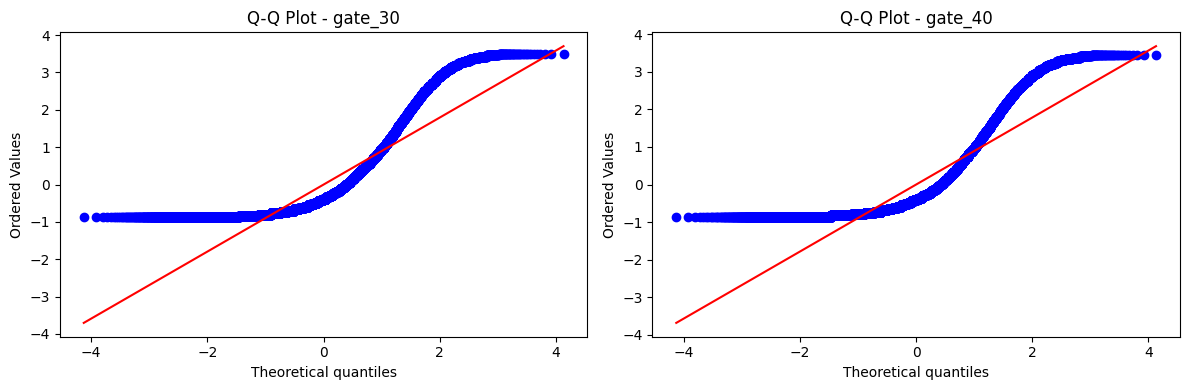

In [13]:
plt.figure(figsize=(12, 4))

for i, game in enumerate(["gate_30", "gate_40"], 1):
    game_data = data[data['version'] == game]['sum_gamerounds']
    
    standardized_data = (game_data - game_data.mean()) / game_data.std()
    
    stat, p_value = stats.kstest(standardized_data, 'norm')
    print(f"Version {game}: p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(f"→ Version {game} shows data is NOT normally distributed.")
    else:
        print(f"→ Version {game} shows data appears normally distributed.")
    
    plt.subplot(1, 2, i) 
    stats.probplot(standardized_data, dist='norm', plot=plt)
    plt.title(f'Q-Q Plot - {game}')

plt.tight_layout()
plt.show()


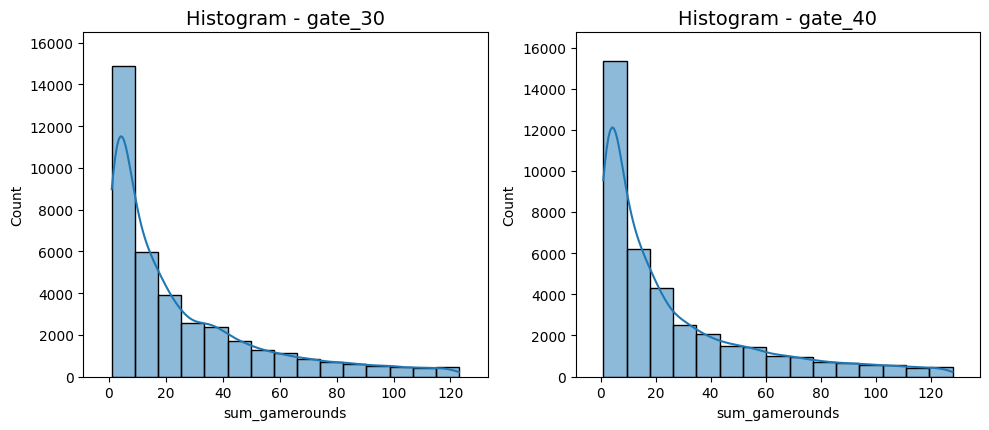

In [14]:
games = ["gate_30", "gate_40"]

plt.figure(figsize=(10, 8))

for i, game in enumerate(games):
    game_data = data[data['version'] == game]['sum_gamerounds']
    
    plt.subplot(2, 2, i + 1)  
    sns.histplot(game_data, kde=True, bins=15)
    plt.xlim(game_data.min() - 10, game_data.max() + 10)  
    max_count = game_data.value_counts().max()
    plt.ylim(0, max_count + max_count * 5)
    plt.title(f'Histogram - {game}', fontsize=14)

plt.tight_layout()
plt.show()


### Checking for Independence

This step sadly cannot be investigated much further, as we do not know anything about how the sample was drawn, or how different the stimuli was in the promotions. This harms our model, as we cannot speak with confidence about this key assumption.

We can of course say that independence is upheld in the regard that we assume each player to be independent from the next player. However, again, we do not know the sources of the sourcing, and it could well be that several of these game players are bots, perhaps numerous of which with the same underlying game code for operating. Or, it could be that several people have several accounts. These are just some ways in which the data cannot easily be checked on this level.

 # Running a Mann-Whitney U Test to Study Link Between Game Rounds Played and Version of Game

On the basis of the aforementioned findings, I instead proceed with a Mann-Whitney U test, which does not require normality. Instead, the assumptions of this test are as follows:
- Independent samples - this is difficult to ascertain based on our analytical position outside the sampling process and being unfamiliar with the game mechanics. As such, it is ignored.
- Measurement level of ordinal or continuous data - this is lived up to by the number of games a player plays being continuous
- Similar distributions - this is lived up to, as shown by the earlier histograms.
- Homogeneity of Variance - As shown below, this assumption is *violated*! However, we continue in spite of this, as this is a less important assumption in the model. While still being noteworthy, a violation of this assumption is not as drastic in comparison to when happing for parametric tests, and is also mostly of consequence in the tails of the distribution - which were earlier shown to be very small. Consequently, we move on.

The hypotheses that are being tested here are:

- H0: There *is no* significant difference in the number of games played between when the gate was placed in the game.
- H1: There *is* a significant in the number of games played between when the gate was placed in the game.

However, as can be seen, there is no significant difference between the two groups (p = 0.88), thus supporting the null hypothesis. As a consequence, I will not proceed with giving descriptive statistics of this data.

In [15]:
group_1 = data[data['version'] == 'gate_30']['sum_gamerounds']
group_2 = data[data['version'] == 'gate_40']['sum_gamerounds']

stat, p_value_levene = stats.levene(group_1, group_2)

print(f"Levene's test statistic = {stat}")
print(f"Levene's p-value = {p_value_levene:.4f}")

if p_value_levene < 0.05:
    print("→ The variances are significantly different between the two versions (violating homogeneity assumption).")
else:
    print("→ The variances are not significantly different between the two versions (homogeneity assumption holds).")


Levene's test statistic = 26.514549533597595
Levene's p-value = 0.0000
→ The variances are significantly different between the two versions (violating homogeneity assumption).


In [16]:
stat, p_value = stats.mannwhitneyu(group_1, group_2)

print(f"U-statistic = {stat}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("→ There is a significant difference between the two game versions.")
else:
    print("→ There is no significant difference between the two game versions.")


U-statistic = 732786682.0
p-value = 0.8831
→ There is no significant difference between the two game versions.


# Testing for Links Between Retention and Game Version

Next we test to see whether there was any link between game version and the retention of users over time. In doing so, there are two tests to run - between game version and 1) retention after 1 day, and 2) retention after 7 days. In doing this, I will use a Chi-Square Test of Independence. This is as it is one of the only non-parametric tests that fit this data. This can be shown through being defined by the assumption of the test, which are:
- Categorical data - This data is either a 1 or a 0 (true or false), and there are only two nominal groups of game versions.
- Independence of observations - as noted earlier, this mostly has to be ignored.
- Random Sampling - Similarly, this also has to be ignored, as we cannot know.
- Sufficient sample size - We need to have at least 5 in each group. As we work with thousands, this is of no issue.
- Mutually exclusive groups - this is upheld, as participants were only in one group.

The hypotheses being tested here are:
- H0: There *is no* significant difference in retention rates between when the gate was placed in the game.
- H1: There *is* a significant in retention rates between when the gate was placed in the game.

As the results show, only one of these tests indicates significance - namely the relationship between when the gate was placed and whether the user returned after 7 days (p < 0.05). As discussed earlier, 12.56% returned after 7 days in the group with the gate placed at level 30, versus 11.99% in the group where the gate was placed at level 40. These differences are incredibly slight. Regardless, it's the only significant finding in all the data.

In [17]:
contingency_retention_1 = pd.crosstab(data['retention_1'], data['version'])

chi2_stat_1, p_value_1, dof_1, expected_1 = stats.chi2_contingency(contingency_retention_1)

print(f"Chi-Square statistic for retention_1 and version = {chi2_stat_1:.4f}")
print(f"p-value for retention_1 and version = {p_value_1:.4f}")
if p_value_1 < 0.05:
    print("→ There is a significant association between retention_1 and version.")
else:
    print("→ There is no significant association between retention_1 and version.")

contingency_retention_7 = pd.crosstab(data['retention_7'], data['version'])

chi2_stat_7, p_value_7, dof_7, expected_7 = stats.chi2_contingency(contingency_retention_7)

print(f"Chi-Square statistic for retention_7 and version = {chi2_stat_7:.4f}")
print(f"p-value for retention_7 and version = {p_value_7:.4f}")
if p_value_7 < 0.05:
    print("→ There is a significant association between retention_7 and version.")
else:
    print("→ There is no significant association between retention_7 and version.")


Chi-Square statistic for retention_1 and version = 0.4922
p-value for retention_1 and version = 0.4829
→ There is no significant association between retention_1 and version.
Chi-Square statistic for retention_7 and version = 5.7100
p-value for retention_7 and version = 0.0169
→ There is a significant association between retention_7 and version.


# Conclusion

In summary, the A/B test shows that there is no significant difference between the two strategies. Consequently, there is no indication that, based on this data, one approach is more successful than driving total amount of user games than the other. 

One could argue that the non-parametric test holds lower validity - which is a general rule of thumb. However, considering that no assumptions of this model are violated, as well as the fact that this test holds up *exceptionally well* in cases of large samples - which is the case here, based on the histograms - this is a minor point of improvement. Regardless, one could attempt to transform the data in a way that could be manipulated by parametric tests. However, this is outside the scope of my abilities, and the nature of, say, log-transformed data, also makes for less concrete interpretations.

When analyzing whether there was an association between user retention and game version, there was indeed a significant, albeit incredibly slight difference in retention rate. It is important to mention that since we were working with a very large dataset, which makes the tests more sensitive to finding differences. So it is important to consider, especially in light of the scale of the effect, whether this holds any *practical significance*.